In [16]:
import pandas as pd
import os
import pymc as pm
import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

In [17]:
data = pd.read_csv('combined_league_data.csv')
data

,Div,Date,Time,HomeTeam,AwayTeam,FTHG,FTAG,FTR,HTHG,HTAG,...,BbAv<2.5,BbAH,BbAHh,BbMxAHH,BbAvAHH,BbMxAHA,BbAvAHA,LBH,LBD,LBA
0,E0,09/08/2019,20:00,Liverpool,Norwich,4,1,H,4.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,E0,10/08/2019,12:30,West Ham,Man City,0,5,A,0.0,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,E0,10/08/2019,15:00,Bournemouth,Sheffield United,1,1,D,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,E0,10/08/2019,15:00,Burnley,Southampton,3,0,H,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,E0,10/08/2019,15:00,Crystal Palace,Everton,0,0,D,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6075,I1,20/05/18,NaN,Milan,Fiorentina,5,1,H,2.0,1.0,...,2.35,18.0,-0.75,2.11,2.03,1.86,1.81,1.80,3.80,4.00
6076,I1,20/05/18,NaN,Napoli,Crotone,2,1,H,2.0,0.0,...,2.78,19.0,-1.25,2.00,1.96,1.94,1.89,1.44,4.60,6.50
6077,I1,20/05/18,NaN,Sassuolo,Roma,0,1,A,0.0,1.0,...,2.57,18.0,0.50,2.06,2.01,1.89,1.85,3.80,3.80,1.85
6078,I1,20/05/18,NaN,Spal,Sampdoria,3,1,H,1.0,0.0,...,2.18,20.0,-1.00,2.13,2.06,1.84,1.80,1.61,4.00,5.20


In [18]:
# General info about the dataset
data_info = data.info()
data_info

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6080 entries, 0 to 6079
Columns: 129 entries, Div to LBA
dtypes: float64(105), int64(15), object(9)
memory usage: 6.0+ MB


In [19]:
# Check for missing values
missing_values = data.isnull().sum()
missing_values

Div            0
Date           0
Time        2280
HomeTeam       0
AwayTeam       0
            ... 
BbMxAHA     3800
BbAvAHA     3800
LBH         4560
LBD         4560
LBA         4560
Length: 129, dtype: int64

In [20]:
# Summary statistics for numeric columns
data.describe()

,FTHG,FTAG,HTHG,HTAG,HS,AS,HST,AST,HF,AF,...,BbAv<2.5,BbAH,BbAHh,BbMxAHH,BbAvAHH,BbMxAHA,BbAvAHA,LBH,LBD,LBA
count,6080.000000,6080.000000,6079.000000,6079.000000,6080.000000,6080.000000,6080.000000,6080.000000,6080.000000,6080.000000,...,2280.000000,2280.000000,2280.000000,2280.000000,2280.000000,2280.000000,2280.000000,1520.000000,1520.000000,1520.000000
mean,1.544408,1.274836,0.679388,0.559796,13.487007,11.194901,4.977632,4.170559,11.770888,12.027467,...,2.062702,21.791228,-0.336513,2.016338,1.955886,1.987645,1.929197,2.916204,4.097605,5.173974
std,1.303191,1.196842,0.837007,0.764894,5.582458,4.894714,2.725259,2.454258,3.875506,4.032122,...,0.410868,4.296320,0.972160,0.204200,0.188980,0.188695,0.176528,2.206602,1.276050,4.979963
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,...,1.400000,13.000000,-3.000000,1.500000,1.440000,1.440000,1.400000,1.060000,2.900000,1.150000
25%,1.000000,0.000000,0.000000,0.000000,9.000000,8.000000,3.000000,2.000000,9.000000,9.000000,...,1.770000,19.000000,-1.000000,1.880000,1.830000,1.860000,1.810000,1.600000,3.300000,2.250000
50%,1.000000,1.000000,0.000000,0.000000,13.000000,11.000000,5.000000,4.000000,12.000000,12.000000,...,1.990000,21.000000,-0.250000,2.000000,1.940000,1.970000,1.920000,2.200000,3.600000,3.400000
75%,2.000000,2.000000,1.000000,1.000000,17.000000,14.000000,7.000000,6.000000,14.000000,15.000000,...,2.250000,23.000000,0.250000,2.120000,2.060000,2.100000,2.040000,3.200000,4.400000,5.750000
max,9.000000,9.000000,5.000000,5.000000,46.000000,31.000000,18.000000,16.000000,28.000000,32.000000,...,4.670000,37.000000,2.500000,3.150000,3.010000,2.960000,2.840000,17.000000,15.000000,51.000000


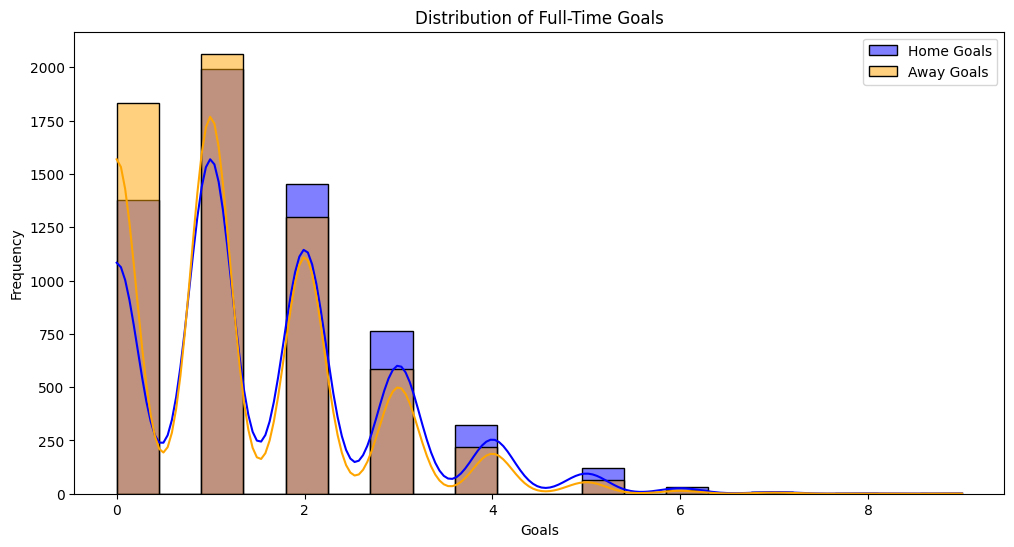

In [21]:
# Visualizing distributions: Full-time goals scored by home and away teams
plt.figure(figsize=(12, 6))
sns.histplot(data['FTHG'], kde=True, bins=20, color='blue', label='Home Goals')
sns.histplot(data['FTAG'], kde=True, bins=20, color='orange', label='Away Goals')
plt.title('Distribution of Full-Time Goals')
plt.xlabel('Goals')
plt.ylabel('Frequency')
plt.legend()
plt.show()

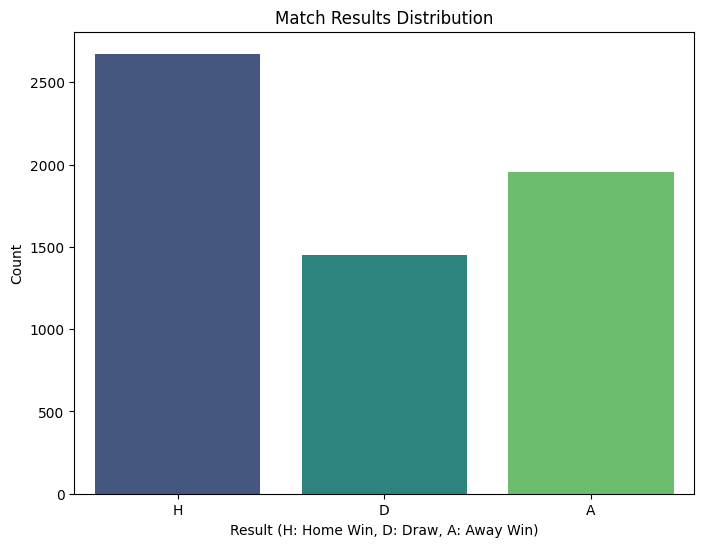

In [22]:
# Visualizing match results distribution
plt.figure(figsize=(8, 6))
sns.countplot(x='FTR', data=data, palette='viridis', order=['H', 'D', 'A'])
plt.title('Match Results Distribution')
plt.xlabel('Result (H: Home Win, D: Draw, A: Away Win)')
plt.ylabel('Count')
plt.show()

# Hypothesis Testing 2: Do High-Scoring Matches Have a Higher Probability of Ending in a Draw?

### Hypotheses:
We are testing if **high-scoring matches** (total goals ≥ threshold) are more likely to end in a **draw** compared to **low-scoring matches** (total goals < threshold).

- **Null Hypothesis (H₀)**: High-scoring matches have the same or a lower probability of ending in a draw compared to low-scoring matches.  

  $ H_0: p_{high} - p_{low} \leq 0 $

- **Alternative Hypothesis (H₁)**: High-scoring matches have a **higher probability** of ending in a draw compared to low-scoring matches.  

  $ H_1: p_{high} - p_{low} > 0 $

This is a **right-tailed test**, focusing on whether the probability of a draw is **significantly greater** for high-scoring matches.

---

### Test Setup:

- **Difference**: We calculate the difference between the proportions of draws in high- and low-scoring matches:

  $ \text{Difference} = p_{high} - p_{low} $

- **Region of Practical Equivalence (ROPE)**:  
  We define a **ROPE** to assess if the difference falls within a range that would be considered practically equivalent:  
  **ROPE**: (-0.05, 0.05), meaning differences smaller than 5 percentage points are considered negligible.

---

### Decision Criteria:

- **Reject H₀** if the **difference** is significantly greater than **0.03** (i.e., high-scoring matches are more likely to end in a draw).
- **Fail to Reject H₀** if the **difference** falls within the **ROPE** (-0.05, 0.05), indicating no meaningful difference. 

In [23]:
data['TotalGoals'] = data['FTHG'] + data['FTAG']
# Calculate basic summary statistics for TotalGoals
total_goals_summary = data['TotalGoals'].describe()

# Show the summary statistics
total_goals_summary

count    6080.000000
mean        2.819243
std         1.669144
min         0.000000
25%         2.000000
50%         3.000000
75%         4.000000
max        10.000000
Name: TotalGoals, dtype: float64

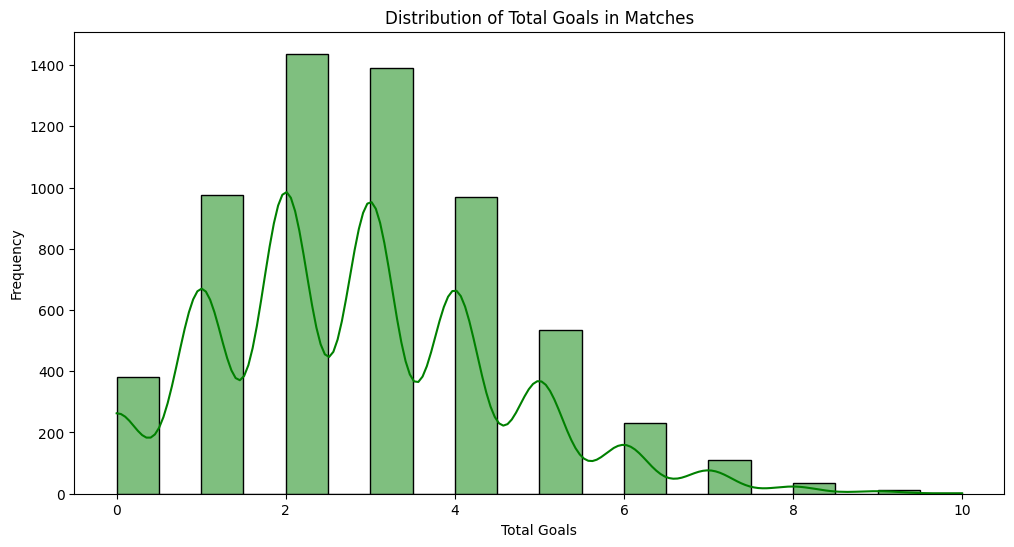

In [24]:
# Visualize the distribution of total goals in matches
plt.figure(figsize=(12, 6))
sns.histplot(data['TotalGoals'], kde=True, bins=20, color='green')
plt.title('Distribution of Total Goals in Matches')
plt.xlabel('Total Goals')
plt.ylabel('Frequency')
plt.show()

### Exploratory Data Analysis (EDA) for Total Goals:

- **Distribution**: The distribution of total goals across matches shows a peak around 2-3 goals, with a tail extending towards higher values (up to 10 total goals).
- **Summary Statistics**:
  - The average total goals per match is **2.82**.
  - The median (50th percentile) is **3**, suggesting that a large number of matches have around 3 goals.
  - The range of total goals is from **0** to **10**, indicating a few high-scoring outlier matches.

### Suggested Threshold:
Based on the distribution, it might make sense to set the **threshold for high-scoring matches** at **3 goals**. Matches with a total of **3 or more goals** can be classified as high-scoring, while those with fewer than 3 goals can be classified as low-scoring.

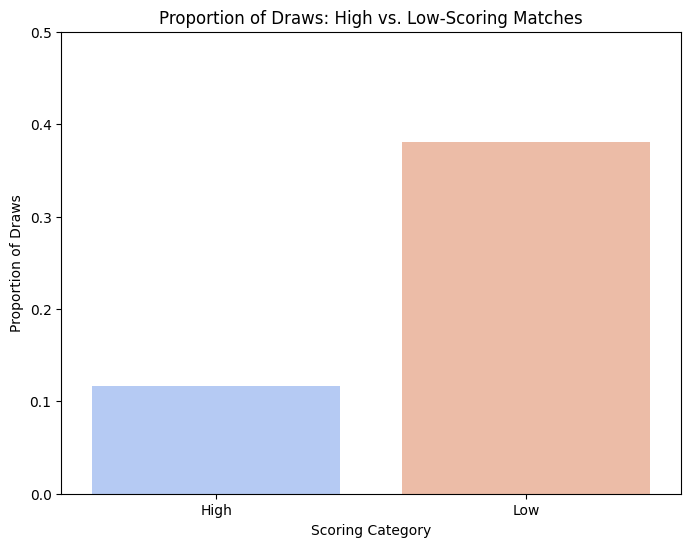

In [25]:
# Create a new column for scoring category based on the threshold
data['ScoringCategory'] = data['TotalGoals'].apply(lambda x: 'High' if x >= 3 else 'Low')

# Calculate the proportion of draws in each scoring category
draw_proportions = data.groupby('ScoringCategory')['FTR'].apply(
    lambda x: (x == 'D').mean()
).reset_index(name='DrawProportion')

# Visualize the proportion of draws in high vs. low-scoring matches
plt.figure(figsize=(8, 6))
sns.barplot(data=draw_proportions, x='ScoringCategory', y='DrawProportion', palette='coolwarm')
plt.title('Proportion of Draws: High vs. Low-Scoring Matches')
plt.xlabel('Scoring Category')
plt.ylabel('Proportion of Draws')
plt.ylim(0, 0.5)
plt.show()

In [26]:
# Display the calculated proportions
draw_proportions

,ScoringCategory,DrawProportion
0,High,0.116895
1,Low,0.381038


### Results:
- The proportion of draws in **high-scoring matches** is approximately **11.7%**.
- The proportion of draws in **low-scoring matches** is significantly higher, at around **38.1%**.

This suggests that low-scoring matches are much more likely to result in a draw than high-scoring matches.

---

We can now move forward with the hypothesis testing:
- **Null Hypothesis ($H_0$)**: High-scoring matches have the same or a lower probability of resulting in a draw compared to low-scoring matches.
- **Alternative Hypothesis ($H_1$)**: High-scoring matches have a lower probability of resulting in a draw compared to low-scoring matches.

In [27]:
# Count the number of draws and total matches in each scoring category
draw_counts = data.groupby('ScoringCategory')['FTR'].apply(lambda x: (x == 'D').sum())
total_counts = data.groupby('ScoringCategory')['FTR'].count()

# Extract counts for high and low-scoring matches
draw_high, draw_low = draw_counts['High'], draw_counts['Low']
total_high, total_low = total_counts['High'], total_counts['Low']

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [p_high, p_low]


Sampling 2 chains for 1_000 tune and 2_000 draw iterations (2_000 + 4_000 draws total) took 8 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics


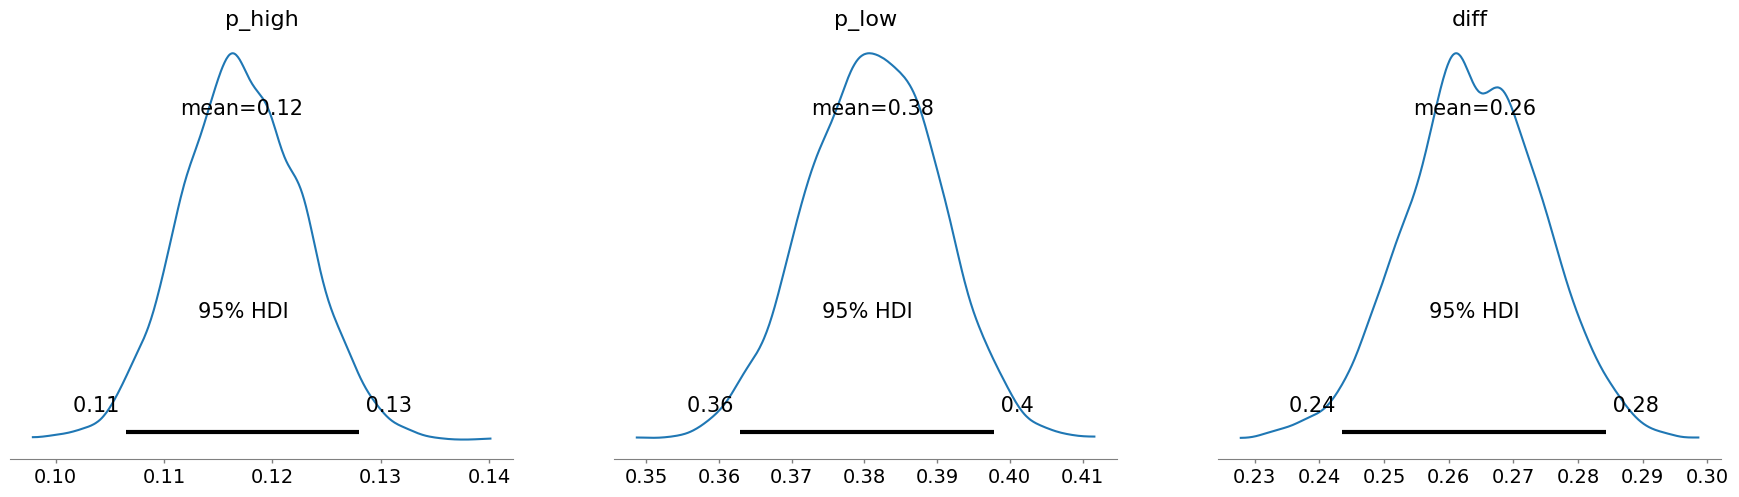

In [28]:
# Define the Bayesian model
with pm.Model() as model:
    # Priors for draw probabilities (Beta prior: uniform)
    p_high = pm.Beta('p_high', alpha=1, beta=1)
    p_low = pm.Beta('p_low', alpha=1, beta=1)
    
    # Likelihood for the observed draws
    draws_high = pm.Binomial('draws_high', n=total_high, p=p_high, observed=draw_high)
    draws_low = pm.Binomial('draws_low', n=total_low, p=p_low, observed=draw_low)
    
    # Difference between high and low draw probabilities
    diff = pm.Deterministic('diff', p_low - p_high)
    
    # Sampling from the posterior, directly returning InferenceData
    trace = pm.sample(2000, cores=2, return_inferencedata=True)

# Summarize and visualize the posterior distributions
az.plot_posterior(trace, var_names=['p_high', 'p_low', 'diff'], hdi_prob=0.95)
plt.show()

In [29]:
# Extract summary statistics for the posterior
posterior_summary = az.summary(trace, var_names=['p_high', 'p_low', 'diff'])
posterior_summary

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
p_high,0.117,0.006,0.107,0.128,0.0,0.0,4109.0,3067.0,1.0
p_low,0.381,0.009,0.364,0.397,0.0,0.0,4216.0,3156.0,1.0
diff,0.264,0.010,0.244,0.283,0.0,0.0,4101.0,2621.0,1.0


To evaluate the **Region of Practical Equivalence (ROPE)**, we will:

1. Define a ROPE for the difference in draw probabilities ($ p_{low} - p_{high} $):
   - Suggested range: $[-0.03, 0.03]$, meaning differences smaller than 3 percentage points are practically negligible.
2. Check the proportion of the posterior distribution of the difference that falls:
   - **Within the ROPE**: Indicates no meaningful difference.
   - **Below the ROPE**: Suggests $ p_{low} $ is significantly smaller than $ p_{high} $.
   - **Above the ROPE**: Suggests $ p_{low} $ is significantly greater than $ p_{high} $.

In [30]:
# Define the ROPE range
rope_min, rope_max = -0.05, 0.05

# Extract the posterior samples for the difference
diff_posterior = trace.posterior['diff'].values.flatten()

# Compute the proportions of the posterior within, below, and above the ROPE
within_rope = np.mean((diff_posterior >= rope_min) & (diff_posterior <= rope_max))
below_rope = np.mean(diff_posterior < rope_min)
above_rope = np.mean(diff_posterior > rope_max)

# Display the results
rope_results = {
    "Proportion within ROPE": within_rope,
    "Proportion below ROPE": below_rope,
    "Proportion above ROPE": above_rope
}
rope_results

{'Proportion within ROPE': 0.0,
 'Proportion below ROPE': 0.0,
 'Proportion above ROPE': 1.0}

<Figure size 800x600 with 0 Axes>

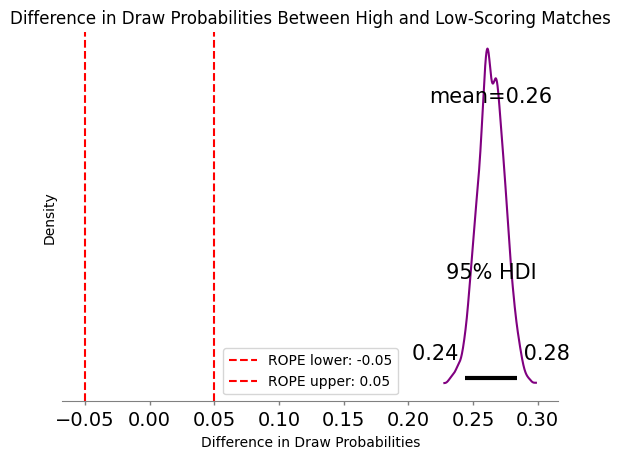

In [31]:
#plot rope
plt.figure(figsize=(8, 6))
az.plot_posterior(diff_posterior, hdi_prob=0.95, color='purple')
plt.axvline(rope_min, color='red', linestyle='--', label=f'ROPE lower: {rope_min}')
plt.axvline(rope_max, color='red', linestyle='--', label=f'ROPE upper: {rope_max}')
plt.title('Difference in Draw Probabilities Between High and Low-Scoring Matches')
plt.xlabel('Difference in Draw Probabilities')
plt.ylabel('Density')
plt.legend()
plt.show()

The Bayesian analysis indicates that the **proportion of the posterior above the ROPE is 1.0**, meaning there is strong evidence that **low-scoring matches have a significantly higher probability of ending in a draw than high-scoring matches**.

### Frequentist Comparison:

To compare results, we will:
1. Perform a **two-proportion z-test** to compare the draw probabilities for high- and low-scoring matches.
2. Compute the p-value to determine if the difference is statistically significant.

In [32]:
from statsmodels.stats.proportion import proportions_ztest
# Counts of draws and total matches for high and low-scoring matches
counts = np.array([draw_low, draw_high])
nobs = np.array([total_low, total_high])
# Perform the two-proportion z-test
z_stat, p_value = proportions_ztest(count=counts, nobs=nobs, alternative='larger')

# Display the z-statistic and p-value
frequentist_results = {
    "Z-Statistic": z_stat,
    "P-Value": p_value
}
frequentist_results

{'Z-Statistic': 24.092242796116704, 'P-Value': 1.5072194045510875e-128}

### Frequentist Test Results:

- **Z-Statistic**: 24.09  
  A very high Z-statistic suggests that the observed difference in draw proportions between high- and low-scoring matches is far from what would be expected under the null hypothesis.

- **P-Value**: $ 1.51 \times 10^{-128}\\ $ 
  This extremely small p-value indicates overwhelming evidence against the null hypothesis. The difference in draw proportions is statistically significant.

---

### Conclusion:

- **Bayesian Analysis**: The posterior probability of the difference being above the ROPE was 1.0, strongly supporting that low-scoring matches have a higher draw probability.
- **Frequentist Analysis**: The p-value confirms this result with high statistical significance.

Both methods are in agreement: **low-scoring matches are significantly more likely to end in a draw compared to high-scoring matches.**


___

# Regression Model 2: Predicting the Probability of a Draw

### Step 1: **Choice of Prior and Likelihood**

In this regression model, the goal is to predict the probability of a draw ($FTR = 'D'$) based on the **total goals** scored in a match.

---

### Model Components:

1. **Likelihood**:
   - The outcome $y$ (draw or not) is binary, so we will use a **Bernoulli likelihood**:
     $$[
     y_i \sim \text{Bernoulli}(p_i)
     $$]
     where $p_i$ is the probability of a draw for match $i$.

2. **Predictor**:
   - The log-odds of $p_i$ are modeled as a linear function of **total goals** ($x_i$):
     $$[
     \text{logit}(p_i) = \beta_0 + \beta_1 x_i
     $$]
     where:
     - $\beta_0$: Intercept.
     - $\beta_1$: Coefficient for total goals.

3. **Priors**:
   - $\beta_0$ and $\beta_1$ will use **normal priors**, reflecting a weakly informative prior belief about their values:
     $$[
     \beta_0, \beta_1 \sim \mathcal{N}(0, 5)
     $$]

---

### Why These Choices?

- **Likelihood**: A Bernoulli likelihood is appropriate for binary outcomes.
- **Predictor**: Log-odds transformation ensures $p_i$ is between 0 and 1.
- **Priors**: Weakly informative priors allow the data to drive the results but still constrain extreme values.

In [41]:
# Prepare the data for regression
data['IsDraw'] = (data['FTR'] == 'D').astype(int)  # Binary target: 1 if draw, 0 otherwise
X = data['TotalGoals'].values
y = data['IsDraw'].values

# Define the Bayesian regression model
with pm.Model() as regression_model:
    # Priors for coefficients
    beta_0 = pm.Normal('beta_0', mu=0, sigma=5)
    beta_1 = pm.Normal('beta_1', mu=0, sigma=5)
    
    # Logistic regression for the probability of a draw
    logit_p = beta_0 + beta_1 * X
    p = pm.math.sigmoid(logit_p)
    
    # Likelihood: Observed data
    likelihood = pm.Bernoulli('likelihood', p=p, observed=y)
    
    # Sampling the posterior
    regression_trace = pm.sample(2000, return_inferencedata=True, cores=4)

# Summarize the regression results
regression_summary = az.summary(regression_trace, var_names=['beta_0', 'beta_1'])

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [beta_0, beta_1]


Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 20 seconds.


In [42]:
regression_summary

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
beta_0,-0.165,0.059,-0.273,-0.054,0.001,0.001,2123.0,3088.0,1.0
beta_1,-0.392,0.021,-0.432,-0.352,0.000,0.000,2107.0,2800.0,1.0


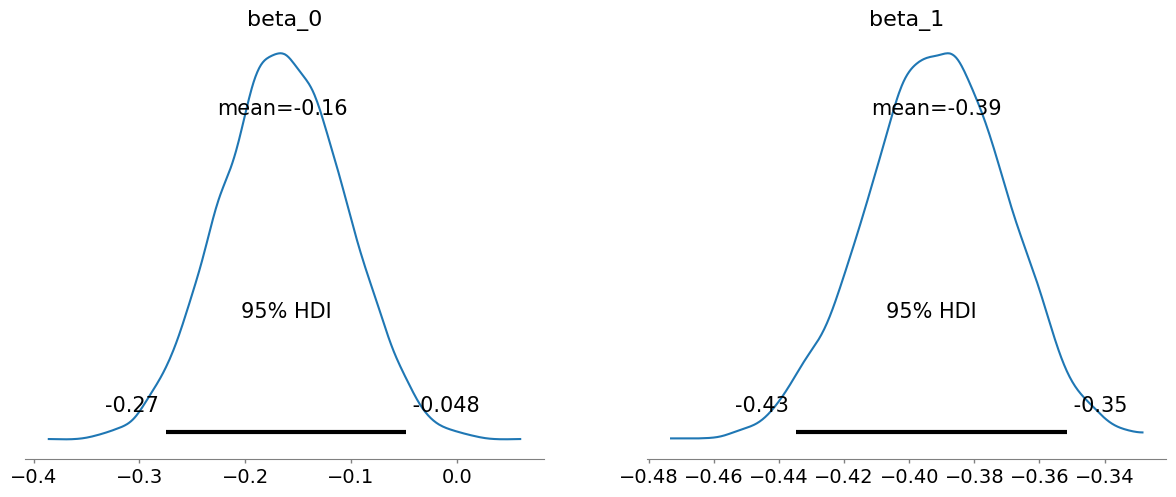

In [43]:
# 1. Plot the posterior distributions of the coefficients
az.plot_posterior(regression_trace, var_names=['beta_0', 'beta_1'], hdi_prob=0.95)
plt.show()

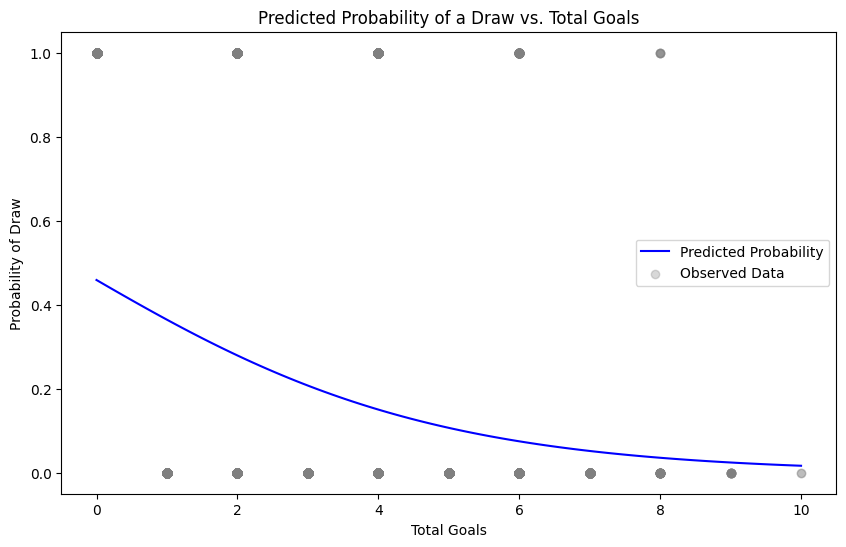

In [44]:
# 2. Plot the predicted probability curve
beta_0_samples = regression_trace.posterior['beta_0'].mean(dim=('chain', 'draw')).values
beta_1_samples = regression_trace.posterior['beta_1'].mean(dim=('chain', 'draw')).values

# Generate predicted probabilities over a range of total goals
x_vals = np.linspace(0, 10, 100)
predicted_probs = 1 / (1 + np.exp(-(beta_0_samples + beta_1_samples * x_vals)))

plt.figure(figsize=(10, 6))
plt.plot(x_vals, predicted_probs, label="Predicted Probability", color="blue")
plt.scatter(X, y, alpha=0.3, color="gray", label="Observed Data")
plt.title("Predicted Probability of a Draw vs. Total Goals")
plt.xlabel("Total Goals")
plt.ylabel("Probability of Draw")
plt.legend()
plt.show()

### Step 2: Posterior Predictive Check

The **posterior predictive check** helps assess how well the model describes the data by generating simulated outcomes from the posterior distributions and comparing them to the observed data.

---

### Process:
1. **Generate Posterior Predictive Samples**:
   - Using the posterior distributions of $\beta_0$ and $\beta_1$, simulate new outcomes ($y_{\text{sim}}$) for the matches.
   - Compare the simulated outcomes to the observed draws.

2. **Visualize Posterior Predictive Distributions**:
   - Plot the predicted versus observed draws across total goals.
   - Check if the model predictions align with the observed data.

---

### Code for Posterior Predictive Check:

In [50]:
# Perform posterior predictive sampling
with regression_model:
    posterior_predictive = pm.sample_posterior_predictive(regression_trace)
# Check the available keys in the posterior predictive object
posterior_predictive.keys()

Sampling: [likelihood]


KeysView(Inference data with groups:
	> posterior_predictive
	> observed_data)